In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from typing import List

Download dataset from Kaggle

In [2]:
with open('kaggle.json') as f:
  credentials = json.load(f)

KAGGLE_API_USERNAME = credentials['username']
KAGGLE_API_KEY = credentials['key']

In [3]:
!KAGGLE_USERNAME={KAGGLE_API_USERNAME} KAGGLE_KEY={KAGGLE_API_KEY} kaggle competitions files avazu-ctr-prediction

name                  size  creationDate         
-------------------  -----  -------------------  
train.gz               1GB  2018-06-20 00:48:07  
sampleSubmission.gz   33MB  2018-06-20 00:48:07  
test.gz              118MB  2018-06-20 00:48:07  


In [4]:
if 'avazu-ctr-prediction.zip' not in os.listdir():
    !KAGGLE_USERNAME={KAGGLE_API_USERNAME} KAGGLE_KEY={KAGGLE_API_KEY} kaggle competitions download -c avazu-ctr-prediction

100%|█████████████████████████████████████▉| 1.19G/1.19G [00:34<00:00, 19.7MB/s]
100%|██████████████████████████████████████| 1.19G/1.19G [00:34<00:00, 37.0MB/s]


In [5]:
!unzip avazu-ctr-prediction.zip

Archive:  avazu-ctr-prediction.zip
  inflating: sampleSubmission.gz     
  inflating: test.gz                 
  inflating: train.gz                


It seems that the train table is quite large, we'll process it in chunks and only pick the two columns relevant for our analysis (hour + clicks). After all, our aggregations are count/sums which can be done on chunks and aggregated further.

In [6]:
aggregated_chunk_data = pd.DataFrame()

In [7]:
chunksize = 10 ** 6
for chunk in pd.read_csv('train.gz', chunksize=chunksize, usecols=['click', 'hour']):
    aggregated_chunk_data = aggregated_chunk_data.append(
        chunk[['click', 'hour']].groupby('hour', as_index=False).agg(['sum', 'count'])
    )
    
aggregated_chunk_data.head()

click        
            sum   count
hour                   
14102100  20792  119006
14102101  23873  137442
14102102  31265  207471
14102103  32830  193355
14102104  40026  264711

In [8]:
aggregated_chunk_data = aggregated_chunk_data['click'].rename(
    columns={'sum': 'clicks', 'count': 'impressions'}
).reset_index()
aggregated_chunk_data.head()

,hour,clicks,impressions
0,14102100,20792,119006
1,14102101,23873,137442
2,14102102,31265,207471
3,14102103,32830,193355
4,14102104,40026,264711


We need one more round of aggregation since there is no guarantee our chunks were randomly aligned by hours

In [9]:
aggregated_data = aggregated_chunk_data.groupby('hour', as_index=False).sum()

aggregated_data.head()

,hour,clicks,impressions
0,14102100,20792,119006
1,14102101,23873,137442
2,14102102,31265,207471
3,14102103,32830,193355
4,14102104,40026,264711


In [10]:
aggregated_data['ctr'] = aggregated_data['clicks'] / aggregated_data['impressions']
aggregated_data['hour_reformated'] = pd.to_datetime('20' + aggregated_data['hour'].astype(str), format='%Y%m%d%H')
aggregated_data.head()

,hour,clicks,impressions,ctr,hour_reformated
0,14102100,20792,119006,0.174714,2014-10-21 00:00:00
1,14102101,23873,137442,0.173695,2014-10-21 01:00:00
2,14102102,31265,207471,0.150696,2014-10-21 02:00:00
3,14102103,32830,193355,0.169791,2014-10-21 03:00:00
4,14102104,40026,264711,0.151206,2014-10-21 04:00:00


Let's create the first deliverable: CTR by hour

<ipython-input-11-377247bcbad4>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-11-377247bcbad4>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(x*100, 2)) + ' %' for x in vals])


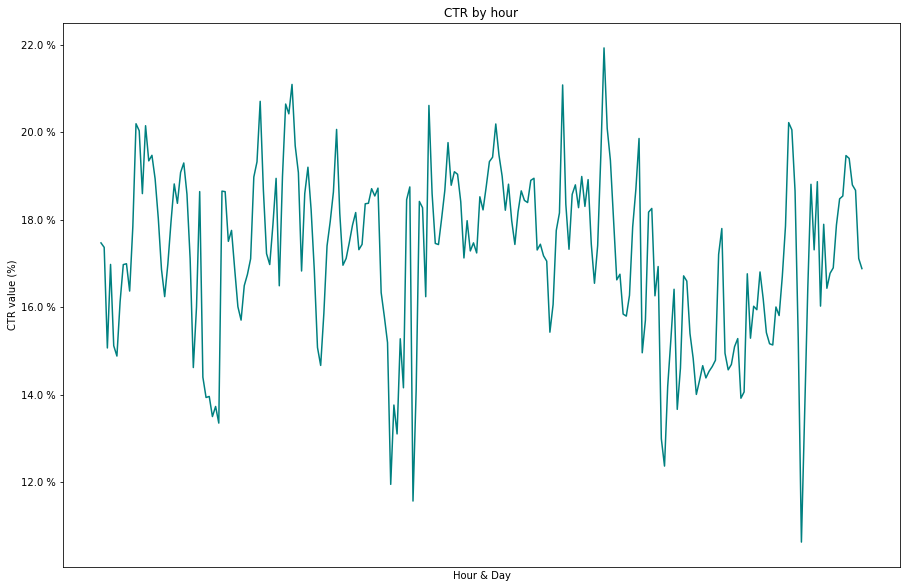

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))

ax.set_xticks([1.5])
ax.set_xticklabels(["Here is 1.5"])
fig.show()

ax.plot(
    aggregated_data['hour_reformated'].tolist(),
    aggregated_data['ctr'].tolist(),
    c='teal',
    label='CTR')

ax.set_title('CTR by hour')
ax.set_xlabel('Hour & Day')
ax.set_ylabel('CTR value (%)')
vals = ax.get_yticks()
ax.set_yticklabels([str(round(x*100, 2)) + ' %' for x in vals])
         
plt.show()

It appears there might be some seasonality, let's check

In [12]:
hourly_data = aggregated_data.groupby(aggregated_data['hour_reformated'].dt.hour, as_index=False).sum()
hourly_data['ctr'] = hourly_data['clicks'] / hourly_data['impressions']
hourly_data.head()

,hour,clicks,impressions,ctr
0,141025500,152429,845178,0.180351
1,141025510,182947,984784,0.185774
2,141025520,215322,1222672,0.176108
3,141025530,243705,1399001,0.174199
4,141025540,305308,1913348,0.159567


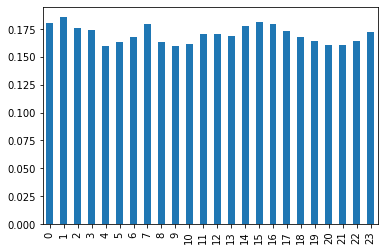

In [13]:
hourly_data['ctr'].plot(kind='bar')
plt.show()

It appears that the seasonality isn't as strong as what we'd suspect. I'll ignore it for now, but the treatment would be quite simple.

Let's first create a prototype of our algorithm before we turn it into a function, let's pick the last 4 hours as our window

In [14]:
aggregated_data['ctr'].rolling(4).mean().shift(1)

0           NaN
1           NaN
2           NaN
3           NaN
4      0.167224
         ...   
235    0.185921
236    0.189727
237    0.190523
238    0.190847
239    0.184964
Name: ctr, Length: 240, dtype: float64

In [15]:
aggregated_data.sort_values('hour_reformated', ascending=True, inplace=True)
# We want to include only past data points in a moving avg / stdev for a given data point, hence the shift
aggregated_data['moving_avg'] = aggregated_data['ctr'].rolling(4).mean().shift(1)
aggregated_data['moving_stdev'] = aggregated_data['ctr'].rolling(4).std().shift(1)
aggregated_data['is_outlier'] = (
    aggregated_data['ctr'] - aggregated_data['moving_avg']
).abs() > 1.5 * aggregated_data['moving_stdev']
aggregated_data.head()

,hour,clicks,impressions,ctr,hour_reformated,moving_avg,moving_stdev,is_outlier
0,14102100,20792,119006,0.174714,2014-10-21 00:00:00,NaN,NaN,False
1,14102101,23873,137442,0.173695,2014-10-21 01:00:00,NaN,NaN,False
2,14102102,31265,207471,0.150696,2014-10-21 02:00:00,NaN,NaN,False
3,14102103,32830,193355,0.169791,2014-10-21 03:00:00,NaN,NaN,False
4,14102104,40026,264711,0.151206,2014-10-21 04:00:00,0.167224,0.011221,False


We could very well test different rolling windows

Note: We don't classify the points where we can't get a full moving window of previous values

In [16]:
num_outliers_per_variant = pd.Series(index=list(range(3, 24)))
for moving_window_size in range(3, 24):
    aggregated_data[f'is_outlier_w_window_of_{moving_window_size}'] = (
        aggregated_data['ctr'] - aggregated_data['ctr'].rolling(moving_window_size).mean().shift(1)
    ).abs() > 1.5 * aggregated_data['ctr'].rolling(moving_window_size).std().shift(1)
    num_outliers_per_variant.loc[moving_window_size] = aggregated_data[f'is_outlier_w_window_of_{moving_window_size}'].sum()

aggregated_data.head()

<ipython-input-16-90b20bcabe53>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  num_outliers_per_variant = pd.Series(index=list(range(3, 24)))


,hour,clicks,impressions,ctr,hour_reformated,moving_avg,moving_stdev,is_outlier,is_outlier_w_window_of_3,is_outlier_w_window_of_4,...,is_outlier_w_window_of_14,is_outlier_w_window_of_15,is_outlier_w_window_of_16,is_outlier_w_window_of_17,is_outlier_w_window_of_18,is_outlier_w_window_of_19,is_outlier_w_window_of_20,is_outlier_w_window_of_21,is_outlier_w_window_of_22,is_outlier_w_window_of_23
0,14102100,20792,119006,0.174714,2014-10-21 00:00:00,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,14102101,23873,137442,0.173695,2014-10-21 01:00:00,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,14102102,31265,207471,0.150696,2014-10-21 02:00:00,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,14102103,32830,193355,0.169791,2014-10-21 03:00:00,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,14102104,40026,264711,0.151206,2014-10-21 04:00:00,0.167224,0.011221,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Let's summarize our results

<AxesSubplot:>

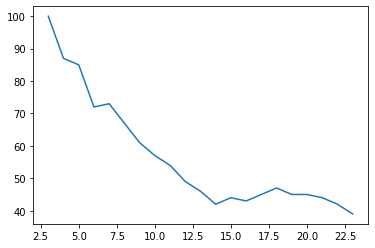

In [17]:
num_outliers_per_variant.plot(kind='line')

We can see that the less datapoints in the moving window, the more outliers we get, most probably due to higher variablity occuring between the values in the moving window and the new value. It also seems, there's not much change in number of outliers identified once we get to 13 dayapoints in a moving window

Let's plot these results (second deliverable)

In [18]:
outliers = aggregated_data[aggregated_data['is_outlier_w_window_of_13'] == True]
outliers.head()

,hour,clicks,impressions,ctr,hour_reformated,moving_avg,moving_stdev,is_outlier,is_outlier_w_window_of_3,is_outlier_w_window_of_4,...,is_outlier_w_window_of_14,is_outlier_w_window_of_15,is_outlier_w_window_of_16,is_outlier_w_window_of_17,is_outlier_w_window_of_18,is_outlier_w_window_of_19,is_outlier_w_window_of_20,is_outlier_w_window_of_21,is_outlier_w_window_of_22,is_outlier_w_window_of_23
14,14102114,35168,174531,0.201500,2014-10-21 14:00:00,0.191682,0.011379,False,False,False,...,True,False,False,False,False,False,False,False,False,False
20,14102120,18195,112017,0.162431,2014-10-21 20:00:00,0.183261,0.011415,True,True,True,...,False,False,False,False,False,False,False,False,False,False
29,14102205,41921,286697,0.146221,2014-10-22 05:00:00,0.185183,0.009867,True,True,True,...,True,True,True,True,True,True,True,True,True,True
32,14102208,46487,322803,0.144010,2014-10-22 08:00:00,0.165948,0.017031,False,False,False,...,True,True,True,True,True,True,True,True,True,True
33,14102209,62410,447783,0.139376,2014-10-22 09:00:00,0.159182,0.019511,False,False,False,...,True,True,True,True,True,True,True,True,True,True


<ipython-input-19-7f36f8eb1da8>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-19-7f36f8eb1da8>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(x*100, 2)) + ' %' for x in vals])


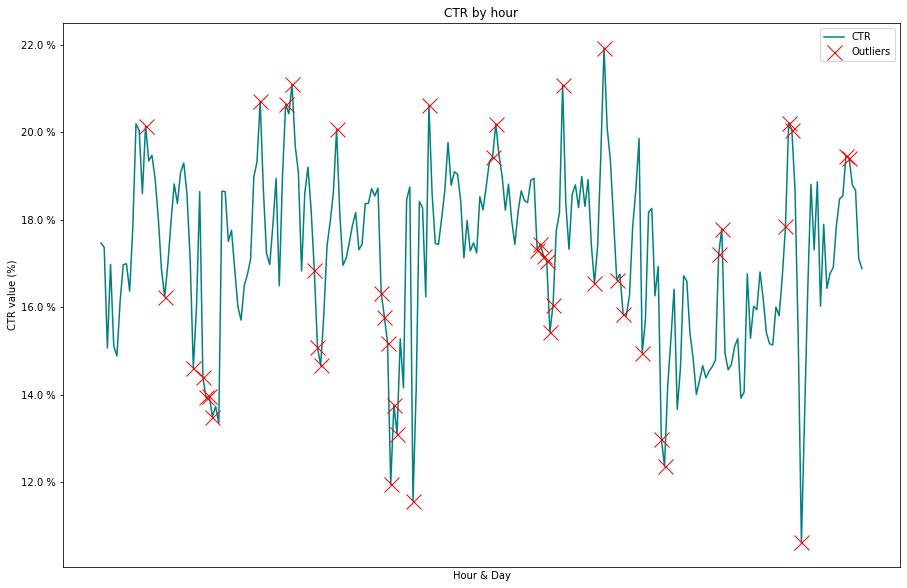

In [19]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))

ax.set_xticks([1.5])
ax.set_xticklabels(["Here is 1.5"])
fig.show()

ax.plot(
    aggregated_data['hour_reformated'].tolist(),
    aggregated_data['ctr'].tolist(),
    c='teal',
    label='CTR')

ax.plot(
    outliers['hour_reformated'],
    outliers['ctr'],
    c='red',
    label='Outliers',
    linestyle='', 
    marker='x',
    markersize=15
)

ax.legend()
ax.set_title('CTR by hour')
ax.set_xlabel('Hour & Day')
ax.set_ylabel('CTR value (%)')
vals = ax.get_yticks()
ax.set_yticklabels([str(round(x*100, 2)) + ' %' for x in vals])
         
plt.show()

We're still getting too many anomalies, in a 10 day period with 240 time units, we'd flag 46 as outliers. I would play around with the standard deviation parameter to improve the algorithm

Let's define our outlier detection algorithm. If it was running in production, our inputs would be:
* data from the window up to the point we're trying to classify
* the value which we're looking to flag by the outlier check
* length of the moving window

Obviously the production version would be more complex with most code spent on getting the data and formatting them into the shape they'd need to be in for ingestion.

In [20]:
def detect_anomaly(previous_data: pd.Series, check_point_value: float) -> bool:
    avg = previous_data.mean()
    stdev = previous_data.std()

    return abs(avg - check_point_value) > 1.5 * stdev

A model example of calling the function

In [21]:
MOVING_WINDOW_LENGTH = 13
chosen_check_point = parse('2014-10-21 14:00:00')
previous_data = aggregated_data[
    aggregated_data['hour_reformated'] < chosen_check_point
].sort_values('hour_reformated', ascending=False).head(MOVING_WINDOW_LENGTH)['ctr']

check_point_value = aggregated_data.loc[
    aggregated_data['hour_reformated'] == chosen_check_point,
    'ctr'
].values[0]

detect_anomaly(previous_data=previous_data, check_point_value=check_point_value)

True

Cleanup

In [22]:
for file in ['sampleSubmission.gz', 'test.gz', 'train.gz', 'avazu-ctr-prediction.zip']: 
    os.remove(file)